# Imports

In [19]:
import os, sys, json
import numpy as np
# Determine project root (parent of notebooks directory)
current_dir = os.path.abspath(os.getcwd())
# If running from project root, notebooks/ may not be in path; handle both cases
if os.path.basename(current_dir).lower() == "notebooks":
    project_root = os.path.abspath(os.path.join(current_dir, ".."))
else:
    # Assume we launched from project root already
    project_root = current_dir

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

try:
    from networks import SpikingNetwork
except ModuleNotFoundError as e:
    raise RuntimeError(f"Failed to import SpikingNetwork from {src_path}: {e}")
try:
    from connections import *
except ModuleNotFoundError as e:
    raise RuntimeError(f"Failed to import connections from {src_path}: {e}")
try: 
    from utils import *
except ModuleNotFoundError as e:
    raise RuntimeError(f"Failed to import utils from {src_path}: {e}")
try:
    from inputs import *
except ModuleNotFoundError as e:
    raise RuntimeError(f"Failed to import inputs from {src_path}: {e}")

# Load config file robustly
config_path = os.path.join(project_root, "configs", "izhikevich_base.json")
config_path = os.path.join(project_root, "configs", "baseline_lif.json")
with open(config_path, "r") as f:
    config = json.load(f)
print("Loaded config from", config_path)
import torch

Loaded config from c:\Users\Work\VSCodeProjects\spiking-network-info-transmission\configs\baseline_lif.json


# Create weight matrices & network

In [20]:
np.random.normal(loc=0.0, scale=1.0, size=(400, 200))

array([[ 1.04549689,  0.7664314 ,  1.32554962, ..., -2.27109755,
        -0.63579617, -0.10438369],
       [ 1.41168032,  1.0738095 ,  0.40922864, ...,  0.05099576,
         0.20961683, -0.24566609],
       [-0.74884583, -0.86334822, -0.31375685, ...,  1.49297383,
        -0.56071725, -2.03575549],
       ...,
       [ 0.78690525,  0.45934055,  0.0363463 , ...,  0.21757755,
        -1.19717956,  0.30891262],
       [ 1.67747718,  1.76989679,  0.00605754, ..., -0.75556369,
        -0.4552314 , -0.34210495],
       [ 1.78229893,  0.38954125, -0.67132095, ..., -0.99638156,
        -0.98461604,  0.65102482]], shape=(400, 200))

No learning for lateral connections.
No learning for feedforward connections.


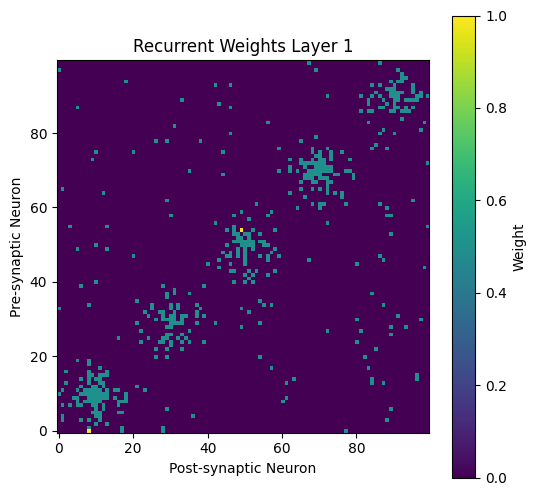

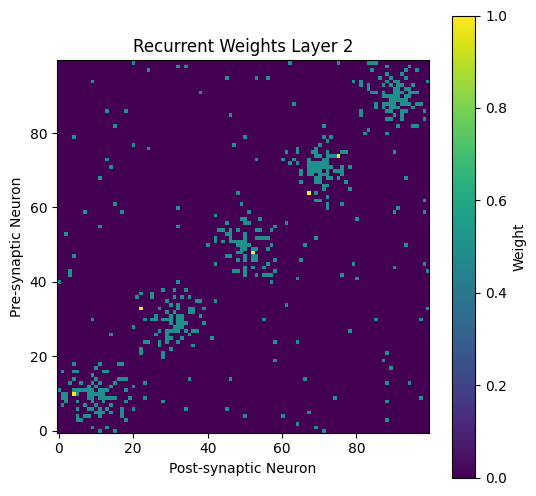

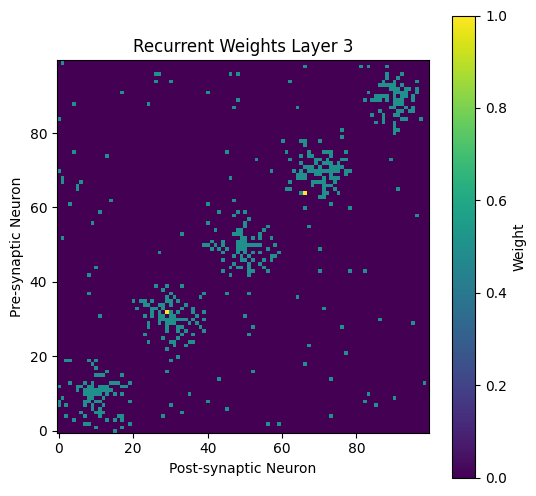

In [21]:
net = SpikingNetwork(config)
ff1 = connect_random(config["n_inputs"], config["n_layer_one"])
ff2 = connect_random(config["n_layer_one"], config["n_layer_two"])
ff3 = connect_random(config["n_layer_two"], config["n_layer_three"])
rec1 = create_clustered_connection_with_density(n_neurons=config["n_layer_one"], num_clusters=config["cluster_size"], weight=config["weight_strength"]) + connect_random(config["n_layer_one"], config["n_layer_one"], p=config["noise_level"]) * config["weight_strength"]
rec2 = create_clustered_connection_with_density(n_neurons=config["n_layer_two"], num_clusters=config["cluster_size"], weight=config["weight_strength"]) + connect_random(config["n_layer_two"], config["n_layer_two"], p=config["noise_level"]) * config["weight_strength"]
rec3 = create_clustered_connection_with_density(n_neurons=config["n_layer_three"], num_clusters=config["cluster_size"], weight=config["weight_strength"]) + connect_random(config["n_layer_three"], config["n_layer_three"], p=config["noise_level"]) * config["weight_strength"]
net.add_weights(ff1, rec1, ff2, rec2, ff3, rec3)
net.build()
visualize_weight_matrix(rec1, title="Recurrent Weights Layer 1")
visualize_weight_matrix(rec2, title="Recurrent Weights Layer 2")
visualize_weight_matrix(rec3, title="Recurrent Weights Layer 3")

torch.Size([400, 100])
torch.Size([400, 100]) torch.Size([400, 100]) torch.Size([400, 100]) torch.Size([400, 100])
Max Noise Values: 0.39034080702586066, Min Noise Values: -0.45524100408863855
Max Layer1 Spikes: 1.0, Min Layer1 Spikes: 0.0


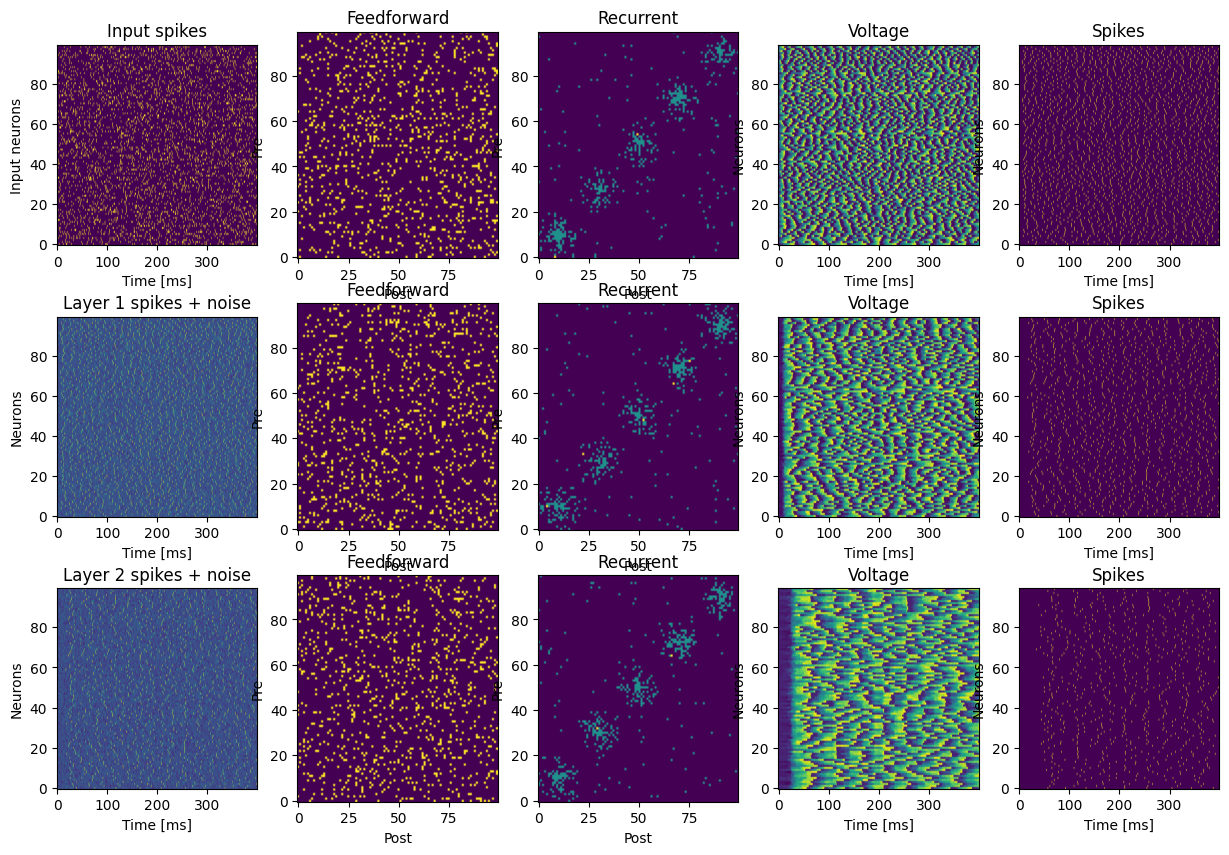

In [22]:
input_data = torch.bernoulli(0.1 * torch.ones(config["time"], config["n_inputs"])).byte()
# initial input to one to one
# try target clusterwise and check activity
print(input_data.shape)
net.run(input_data, input_mean=config["noise_mean"], input_scale=config["noise_scale"])
# add check if connection weight have increased
net.plot_last(config)


torch.Size([400, 100])
torch.Size([400, 100]) torch.Size([400, 100]) torch.Size([400, 100]) torch.Size([400, 100])
Max Noise Values: 0.41651799088211616, Min Noise Values: -0.4044658060395936
Max Layer1 Spikes: 1.0, Min Layer1 Spikes: 0.0


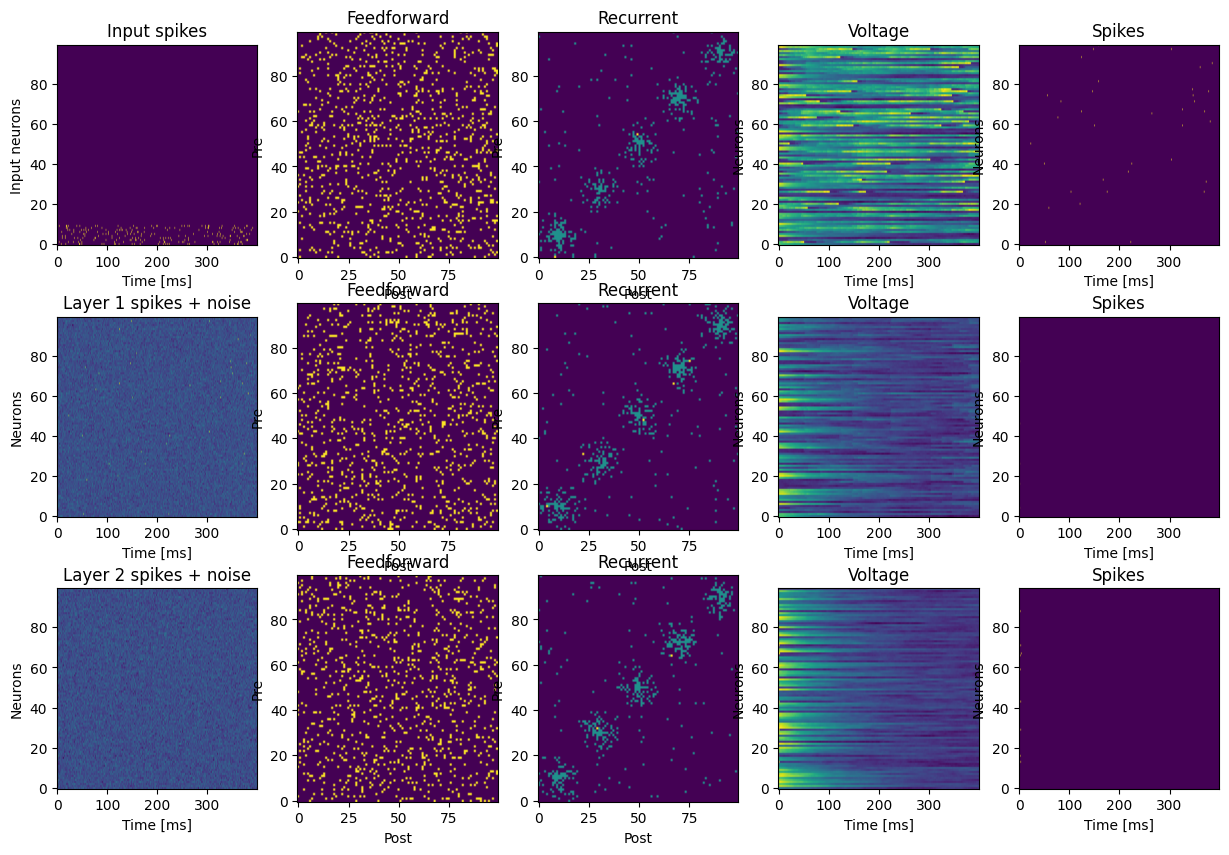

In [23]:
# Params
n_inputs   = 100
n_neurons  = 100
dt         = 1.0
sim_length = 400
T          = net.time

# Stimulate a group of neurons
target_idx  = np.arange(10)
target_rate = 50.0
bg_rate     = 0.0

poisson_spikes = poisson_input(
    T, n_inputs, dt,
    target_idx,
    target_rate,
    bg_rate,
    batch_size=1
)
I_ext = torch.from_numpy(poisson_input(T, config["n_inputs"], dt, target_idx, target_rate, bg_rate))

I_ext = I_ext.squeeze(1)
print(I_ext.shape)
net.run(I_ext, input_mean=config["noise_mean"], input_scale=config["noise_scale"])
# add check if connection weight have increased
net.plot_last(config)

(array([[ 1.,  0.,  8., ...,  8.,  2.,  0.],
        [ 0.,  1.,  7., ...,  5.,  1.,  0.],
        [ 0.,  1.,  5., ...,  7.,  0.,  0.],
        ...,
        [ 0.,  1., 10., ...,  3.,  0.,  0.],
        [ 0.,  0., 12., ...,  2.,  0.,  0.],
        [ 0.,  1., 10., ...,  4.,  0.,  0.]], shape=(400, 10)),
 array([-0.4146812 , -0.32850956, -0.24233792, -0.15616627, -0.06999463,
         0.01617701,  0.10234866,  0.1885203 ,  0.27469195,  0.36086359,
         0.44703523]),
 <a list of 400 BarContainer objects>)

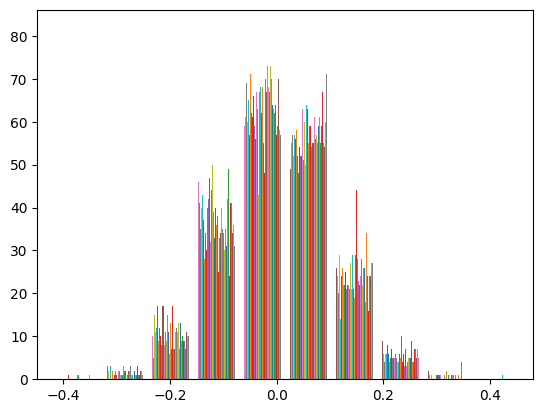

In [24]:
plt.hist(np.random.normal(loc=config["noise_mean"], scale=config["noise_scale"], size=(200, 400)))
